[*********************100%***********************]  1 of 1 completed
C:\Users\nando\AppData\Local\Temp\ipykernel_2544\3531490994.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preco_entrada = float(precos.iloc[i])
C:\Users\nando\AppData\Local\Temp\ipykernel_2544\3531490994.py:54: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preco_saida = float(precos.iloc[i + 1])
C:\Users\nando\AppData\Local\Temp\ipykernel_2544\3531490994.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preco_entrada = float(precos.iloc[i])
C:\Users\nando\AppData\Local\Temp\ipykernel_2544\3531490994.py:61: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. 


Resumo do Backtest
Capital Final: 1.20 (19.65%)
Drawdown Máximo: -23.05%
Número de Operações: 344
Taxa de Acerto: 50.58%


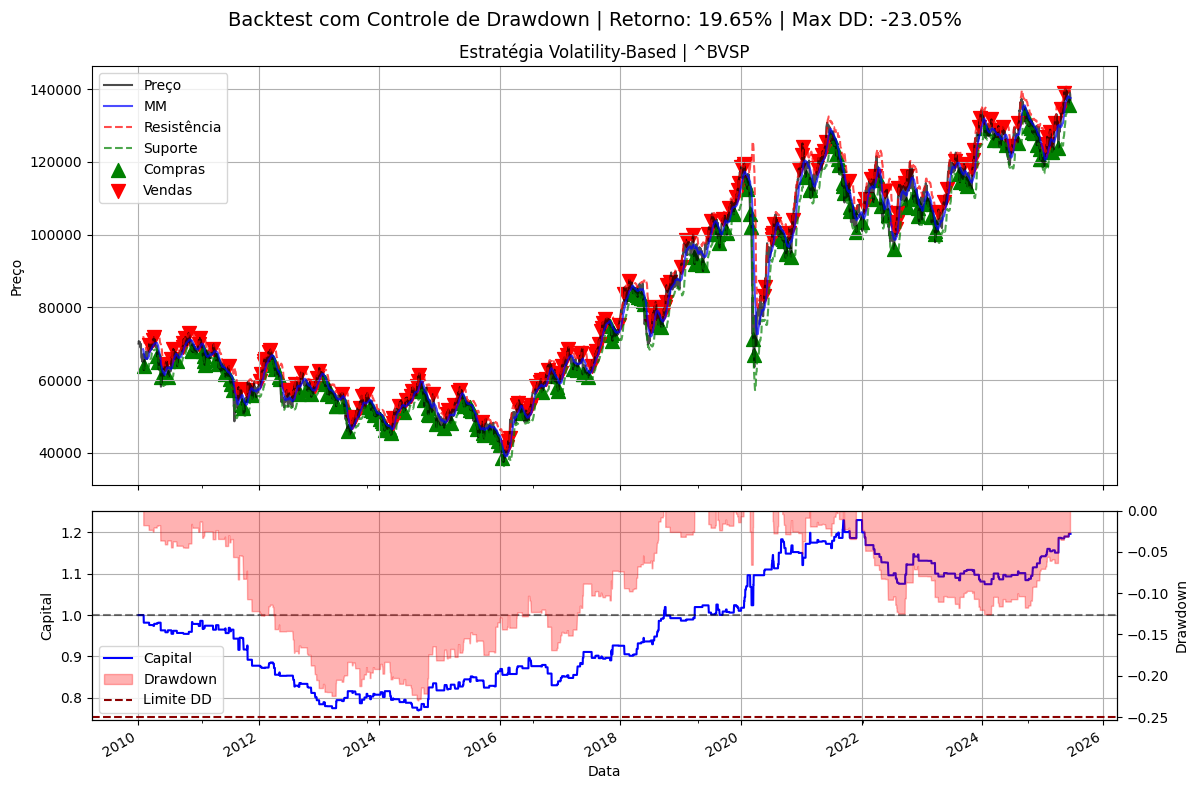


Últimas 5 operações:
data_entrada data_saida   tipo     lucro  capital_antes  capital_depois
  2025-03-17 2025-03-18  venda -0.004899       1.156596        1.150929
  2025-04-08 2025-04-09 compra  0.031178       1.150929        1.186813
  2025-04-24 2025-04-25  venda -0.001181       1.186813        1.185411
  2025-05-13 2025-05-14  venda  0.003886       1.185411        1.190018
  2025-06-09 2025-06-10 compra  0.005431       1.190018        1.196481


In [47]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== PARAMETROS AJUSTAVEIS =====
ticker = '^BVSP'
data_inicio = '2010-01-01'
data_fim = None  # ou '2025-06-18' por exemplo
janela_volatilidade = 20  # dias (1 mês ~ 20 dias úteis)
desvio_padrao = 1.7  # múltiplo do desvio padrão
max_drawdown = -0.25  # drawdown máximo permitido

# ===== 1. BAIXAR DADOS =====
dados = yf.download(ticker, start=data_inicio, end=data_fim, auto_adjust=True)
precos = dados['Close']

# ===== 2. CALCULAR BANDA DE VOLATILIDADE =====
media = precos.rolling(janela_volatilidade).mean()
vol = precos.rolling(janela_volatilidade).std()
res = media + desvio_padrao * vol
sup = media - desvio_padrao * vol

# ===== 3. SINAIS DE ENTRADA =====
sinais = pd.DataFrame(index=precos.index)
sinais['preco'] = precos
sinais['res'] = res
sinais['sup'] = sup
sinais['compra'] = (precos < sup) & (precos.shift(1) >= sup.shift(1))
sinais['venda'] = (precos > res) & (precos.shift(1) <= res.shift(1))

# ===== 4. SIMULACAO DE TRADES COM CONTROLE DE DRAWDOWN =====
capital = 1.0
max_capital = capital
capital_hist = [capital]
datas = [precos.index[0]]
drawdowns = [0.0]
operacoes = []
stop_acionado = False

for i in range(1, len(sinais) - 1):
    if stop_acionado:
        capital_hist.append(capital_hist[-1])
        datas.append(precos.index[i])
        drawdowns.append(drawdowns[-1])
        continue

    entrada = False
    lucro = 0.0
    tipo_op = 'hold'

    if sinais['compra'].iloc[i]:
        preco_entrada = float(precos.iloc[i])
        preco_saida = float(precos.iloc[i + 1])
        lucro = (preco_saida - preco_entrada) / preco_entrada
        tipo_op = 'compra'
        entrada = True

    elif sinais['venda'].iloc[i]:
        preco_entrada = float(precos.iloc[i])
        preco_saida = float(precos.iloc[i + 1])
        lucro = (preco_entrada - preco_saida) / preco_entrada
        tipo_op = 'venda'
        entrada = True

    if entrada:
        capital = float(capital * (1 + lucro))
        operacoes.append({
            'data_entrada': precos.index[i],
            'data_saida': precos.index[i + 1],
            'tipo': tipo_op,
            'lucro': float(lucro),
            'capital_antes': float(capital_hist[-1]),
            'capital_depois': float(capital)
        })

    capital = float(capital)
    max_capital = float(max(float(max_capital), float(capital)))
    drawdown = (capital - max_capital) / max_capital

    capital_hist.append(capital)
    datas.append(precos.index[i + 1])
    drawdowns.append(drawdown)

    if drawdown <= max_drawdown:
        print(f"Stop acionado em {precos.index[i + 1]}: Drawdown {drawdown:.2%}")
        stop_acionado = True

# ===== 5. RESULTADOS =====
resultados = pd.DataFrame({
    'Data': datas,
    'Capital': capital_hist,
    'Drawdown': drawdowns
}).set_index('Data')

operacoes_df = pd.DataFrame(operacoes)

retorno_total = (capital - 1) * 100
max_dd = resultados['Drawdown'].min() * 100
num_operacoes = len(operacoes)
taxa_acerto = (operacoes_df['lucro'] > 0).mean() * 100 if num_operacoes > 0 else 0

print("\n" + "=" * 50)
print("Resumo do Backtest")
print("=" * 50)
print(f"Capital Final: {capital:.2f} ({retorno_total:.2f}%)")
print(f"Drawdown Máximo: {max_dd:.2f}%")
print(f"Número de Operações: {num_operacoes}")
print(f"Taxa de Acerto: {taxa_acerto:.2f}%" if num_operacoes > 0 else "Taxa de Acerto: N/A")
print("=" * 50)

# ===== 6. GRAFICO =====
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax1.plot(precos, label='Preço', color='black', alpha=0.7)
ax1.plot(media, label='MM', color='blue', alpha=0.7)
ax1.plot(res, label='Resistência', color='red', linestyle='--', alpha=0.7)
ax1.plot(sup, label='Suporte', color='green', linestyle='--', alpha=0.7)

if not operacoes_df.empty:
    compras = operacoes_df[operacoes_df['tipo'] == 'compra']
    vendas = operacoes_df[operacoes_df['tipo'] == 'venda']
    ax1.scatter(compras['data_entrada'], precos.loc[compras['data_entrada']], marker='^', color='green', s=100, label='Compras')
    ax1.scatter(vendas['data_entrada'], precos.loc[vendas['data_entrada']], marker='v', color='red', s=100, label='Vendas')

ax1.set_title(f'Estratégia Volatility-Based | {ticker}')
ax1.set_ylabel('Preço')
ax1.legend()
ax1.grid(True)

resultados['Capital'].plot(ax=ax2, color='blue', label='Capital')
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax2.set_ylabel('Capital')
ax2.grid(True)

ax3 = ax2.twinx()
ax3.fill_between(resultados.index, resultados['Drawdown'], 0, where=resultados['Drawdown'] < 0, color='red', alpha=0.3, label='Drawdown')
ax3.set_ylabel('Drawdown')
ax3.set_ylim(min(resultados['Drawdown']) * 1.1, 0)
ax3.axhline(y=max_drawdown, color='darkred', linestyle='--', label='Limite DD')

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='lower left')

plt.suptitle(f'Backtest com Controle de Drawdown | Retorno: {retorno_total:.2f}% | Max DD: {max_dd:.2f}%', fontsize=14)
plt.tight_layout()
plt.show()

# Exportar CSV (opcional)
resultados.to_csv('resultados_backtest.csv')
operacoes_df.to_csv('operacoes_detalhadas.csv', index=False)

if not operacoes_df.empty:
    print("\nÚltimas 5 operações:")
    print(operacoes_df.tail().to_string(index=False))


In [49]:
pip install git+https://github.com/FernandoTSI/volforecast.git


  Cloning https://github.com/FernandoTSI/volforecast.git to c:\users\nando\appdata\local\temp\pip-req-build-p9_q23q2
  Resolved https://github.com/FernandoTSI/volforecast.git to commit 0942b466d31f3976ddf3739bb7ea41e77767cfda
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for volforecast: filename=volforecast-0.1.0-py3-none-any.whl size=2440 sha256=f64ff13426a53f0b6d39158bd1c52874848183382e6d3f852b656047fbcc1080
  Stored in directory: C:\Users\nando\AppData\Local\Temp\pip-ephem-wheel-cache-pcgbnmcq\wheels\3e\64\cd\5d67a6ed12aa642f70758f80c2de30ce48b3aabf196442b23b
Successfully built volforecast
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/FernandoTSI/volforecast.git 'C:\Users\nando\AppData\Local\Temp\pip-req-build-p9_q23q2'


In [50]:
from volforecast.core import VolForecastStrategy

# Exemplo com parâmetros padrão
vf = VolForecastStrategy(
    ticker="^BVSP",
    window_vol=20,         # Janela da volatilidade (ex: 20 dias)
    desvio_std=1.7,        # Nível das bandas
    max_drawdown=0.25,     # Stop por drawdown
    start="2020-01-01",    # Data inicial
    end=None,              # Data final (None = hoje)
    freq="daily"           # Frequência: daily, weekly etc.
)

resultados, operacoes = vf.run()
vf.plot()
vf.summary()


ImportError: cannot import name 'VolForecastStrategy' from 'volforecast.core' (D:\anaconda3\envs\pair-env\lib\site-packages\volforecast\core.py)